### Decomposing measures using PCA and t-sne

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none" # use all for maximum output

from Wind.Results import DBResults, DBMeasures
from Wind.Util.Maps import create_mapbox_plot
from Wind.Private.DBConfig import mapbox_token
from Wind.Private.DBConfig import mongolocaltest, mongolocal, mongolocalmeasures

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from matplotlib.colors import DivergingNorm

import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import pearsonr, kendalltau,spearmanr, normaltest
import scipy.stats as stats

from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as skl

import sklearn
print('sklearn version :',sklearn.__version__)

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



sklearn version : 0.22.1


##### Internal Functions

In [3]:
def create_lat_lon(sites):
   list_sites = sites['site'].tolist()
   latlon_df = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/20190823Summary_file.csv')
   df = latlon_df.loc[latlon_df['site_number'].isin(list_sites)]
   return df

In [4]:
# plots 2x2 figure from PCA projection on 3 dims - similar articulo feng
def plot_PCA3(rater, projected_pca, min, max, file, title):
   plt.figure(figsize=(20,20))  
   print(rater.shape, rater.min(), rater.max())
   # Simula figura del articulo
   fig = plt.figure(figsize=(12,10))
   fig.suptitle(title, fontsize=14)
   ax1 = fig.add_subplot(221, projection='3d')
   ax1.scatter(projected_pca['PCA0'], projected_pca['PCA1'], projected_pca['PCA2'], c=rater, s=5, 
           cmap=plt.cm.get_cmap('Spectral',10), alpha=0.5, 
           norm = mpl.colors.Normalize(vmin=min,vmax=max))
   ax1.set_xlabel("PC1")
   ax1.set_ylabel("PC2")
   ax1.set_zlabel("PC3")
   ax1.set_title("PCA subplot 3D")

   ax2 = fig.add_subplot(222)
   ax2.set_title('PCA subplot 2D')
   ax2.set(xlabel = 'PC1', ylabel = 'PC2')
   ax2.scatter(projected_pca['PCA0'], projected_pca['PCA1'], c= rater, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10),
             norm = mpl.colors.Normalize(vmin=min,vmax=max))
    
   ax3 = fig.add_subplot(223)
   ax3.set_title('PCA subplot 2D')
   ax3.set(xlabel = 'PC2', ylabel = 'PC3')
   ax3.scatter(projected_pca['PCA1'], projected_pca['PCA2'], c = rater, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10),
             norm = mpl.colors.Normalize(vmin=min,vmax=max))

   ax4 = fig.add_subplot(224)
   ax4.set_title('PCA subplot 2D')
   ax4.set(xlabel = 'PC1', ylabel = 'PC3')
   f = ax4.scatter(projected_pca['PCA0'], projected_pca['PCA2'], c = rater, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10),
             norm = mpl.colors.Normalize(vmin=min,vmax=max))
   fig.colorbar(f,ax = [ax1,ax2,ax3,ax4], shrink=0.5)
   plt.show()
   fig.savefig('e:/figures/'+ file +'.png', dpi=300)
   return

In [5]:
query={'experiment':'JM_CNN_sep_2l_FULL', 'status':'done'}
results = DBResults(conn=mongolocal)
results.retrieve_results(query)

results.sample(1.0)
a12 = results.extract_result(dset='test', summary='sum', horizon = '12h')
a6  = results.extract_result(dset='test', summary='sum', horizon='6h')
a1  = results.extract_result(dset='test', summary='sum', horizon='1h')

##### Database Queries

In [6]:
query={'experiment':'JM_CNN_sep_2l_FULL', 'status':'done'}
# JM_RF_s2s_2, MLP_s2s_2
results = DBResults(conn=mongolocal)
results.retrieve_results(query)

results.sample(1.0)
a12 = results.extract_result(dset='test', summary='sum', horizon = '12h')
a6  = results.extract_result(dset='test', summary='sum', horizon='6h')
a1  = results.extract_result(dset='test', summary='sum', horizon='1h')

a12 = a12[a12[:,0].argsort()] # we sort by first column
a6 = a6[a6[:,0].argsort()] # we sort by first column
a1 = a1[a1[:,0].argsort()] # we sort by first column

measure = DBMeasures(conn=mongolocalmeasures)
measure.retrieve_measures()

a = a12

df_states = pd.read_csv('e:/Wind$JM/analysis_final_results_experiments/site-state/20191225SummaryFile(0.6)-arreglado.csv')

### We create df_data as master dataframe with all the measures

In [7]:
b1=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend12h')
b2=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SampEnt')
b3=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend24h')
b4=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Trend1m')
b5=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season24h')
b6=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Season1m')
b7=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='SpecEnt')
b8=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Stab1w')
b9=measure.extract_measure_sites(sites= a[:,0], var='wind_speed', measure='Lump1w')

t1=measure.extract_measure_sites(sites= a[:,0], var='temperature', measure='Trend12h')
t2=measure.extract_measure_sites(sites= a[:,0], var='temperature', measure='SampEnt')
t3=measure.extract_measure_sites(sites= a[:,0], var='temperature', measure='Trend24h')
t4=measure.extract_measure_sites(sites= a[:,0], var='temperature', measure='Trend1m')
t5=measure.extract_measure_sites(sites= a[:,0], var='temperature', measure='Season24h')
t6=measure.extract_measure_sites(sites= a[:,0], var='temperature', measure='Season1m')
t7=measure.extract_measure_sites(sites= a[:,0], var='temperature', measure='SpecEnt')
t8=measure.extract_measure_sites(sites= a[:,0], var='temperature', measure='Stab1w')
t9=measure.extract_measure_sites(sites= a[:,0], var='temperature', measure='Lump1w')

In [8]:
df_data = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L_12h': a12[:,1], 'CNN_sep_2L_6h': a6[:,1],
                      'CNN_sep_2L_1h': a1[:,1],
                     'Trend12h_wind_speed':b1[:,1], 
                     'Trend24h_wind_speed':b3[:,1], 'Trend1m_wind_speed':b4[:,1],
                     'Season24h_wind_speed':b5[:,1], 'Season1m_wind_speed':b6[:,1], 'Season12h_wind_speed':b7[:,1],
                     'SampEnt_wind_speed':b2[:,1], 'SpecEnt_wind_speed':b7[:,1],
                     'Stab1w_wind_speed':b8[:,1], 'Lump1w_wind_speed':b9[:,1]})
df_data = df_data.dropna() # hay algun null por ahi limpiamos las filas erroneas

### Scatterplot Sampent with each prediction horizon 1h, 6h, 12h

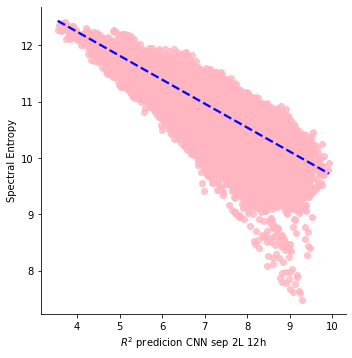

In [9]:
#12h
df_tmp = pd.DataFrame({'x':a12[:,1], 'y': b7[:,1]})

snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "lightpink"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L 12h', 'Spectral Entropy')

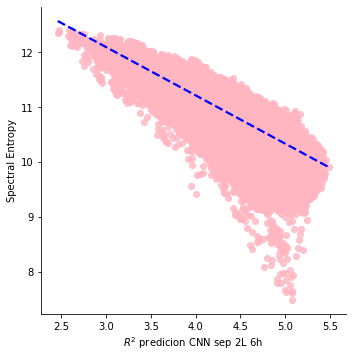

In [10]:
#6h
df_tmp = pd.DataFrame({'x':a6[:,1], 'y': b7[:,1]})

snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "lightpink"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L 6h', 'Spectral Entropy')

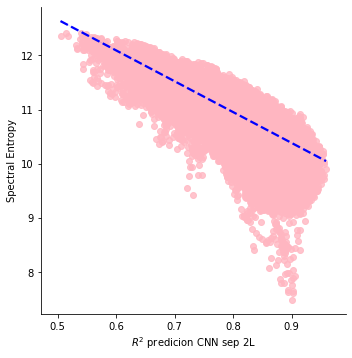

In [11]:
#1h
df_tmp = pd.DataFrame({'x':a1[:,1], 'y': b7[:,1]})

snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "lightpink"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L', 'Spectral Entropy')

### temperature analysis

In [12]:
# dataframe preparation


In [13]:
# dataframe preparation
df_data_temp = pd.DataFrame({'test':a[:,0], 'CNN_sep_2L_12h': a12[:,1], 'CNN_sep_2L_6h': a6[:,1],
                      'CNN_sep_2L_1h': a1[:,1],
                     'Trend12h_temperature':t1[:,1], 
                     'Trend24h_temperature':t3[:,1], 'Trend1m_temperature':t4[:,1],
                     'Season24h_temperature':t5[:,1], 'Season1m_temperature':t6[:,1], 'Season12h_temperatured':t7[:,1],
                     'SampEnt_temperature':t2[:,1], 'SpecEnt_temperature':t7[:,1],
                     'Stab1w_temperature':t8[:,1], 'Lump1w_temperature':t9[:,1]})
df_data_temp = df_data_temp.dropna() # hay algun null por ahi limpiamos las filas erroneas

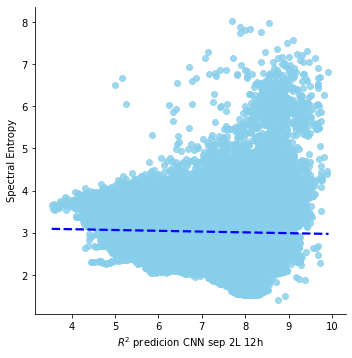

In [14]:
#12h
df_tmp = pd.DataFrame({'x':a12[:,1], 'y': t7[:,1]})

snsplot = sns.lmplot(x='x', y='y', palette= sns.color_palette("Reds"), data = df_tmp, 
                     robust=True, scatter_kws={"color": "skyblue"}, line_kws={"color": "blue", "ls":"--"})
snsplot.set_axis_labels('$R^2$ predicion CNN sep 2L 12h', 'Spectral Entropy')

### PCA analysis 

In [15]:
df_forPCA = pd.DataFrame({ 
                     'Trend12h_wind_speed':b1[:,1], 
                     'Trend24h_wind_speed':b3[:,1], 'Trend1m_wind_speed':b4[:,1],
                     'Season24h_wind_speed':b5[:,1], 'Season1m_wind_speed':b6[:,1], 'Season12h_wind_speed':b7[:,1],
                     'SampEnt_wind_speed':b2[:,1], 'SpecEnt_wind_speed':b7[:,1],
                     'Stab1w_wind_speed':b8[:,1], 'Lump1w_wind_speed':b9[:,1]})
df_forPCA = df_forPCA.dropna()
#data_sampled = data.sample(n=50000)

In [16]:
print(df_forPCA.columns)

Index(['Trend12h_wind_speed', 'Trend24h_wind_speed', 'Trend1m_wind_speed',
       'Season24h_wind_speed', 'Season1m_wind_speed', 'Season12h_wind_speed',
       'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
       'Lump1w_wind_speed'],
      dtype='object')


In [17]:
pca = PCA(3)  # project from 12 to 2 dimensions
pca.fit(df_forPCA)
projected = pd.DataFrame(pca.transform(df_forPCA), columns=['PCA%i' % i for i in range(3)], index=df_forPCA.index)
print(df_forPCA.shape)
print(projected.shape)

(126661, 10)
(126661, 3)


In [18]:
print(df_data['CNN_sep_2L_1h'].max())

0.9589249813832003


##### PCA plot 1h, 6h, 12h wind speed

##### Limits are minimum and maximum values

(126661,) 0.5050298192361149 0.9589249813832003


<Figure size 1440x1440 with 0 Axes>

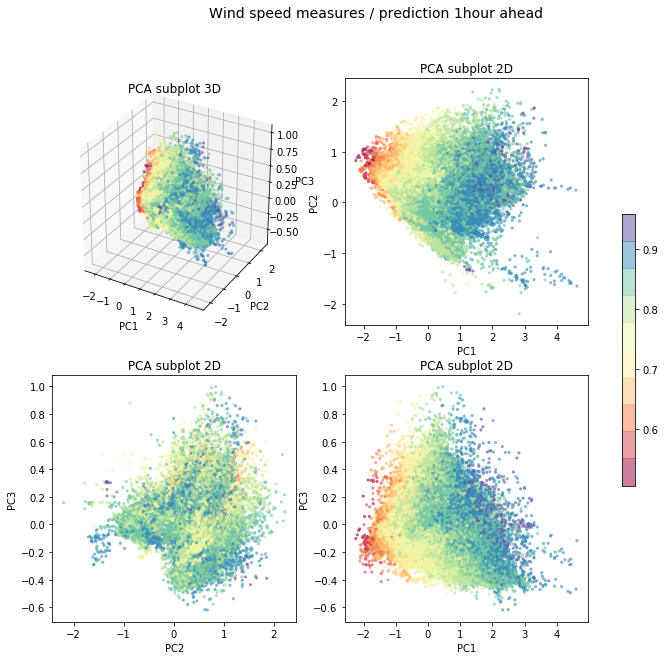

In [19]:
plot_PCA3(df_data.CNN_sep_2L_1h, projected, df_data.CNN_sep_2L_1h.min(),df_data.CNN_sep_2L_1h.max(),
          'wind_speed_1h', 'Wind speed measures / prediction 1hour ahead')

(126661,) 2.4599077151215445 5.488184120301994


<Figure size 1440x1440 with 0 Axes>

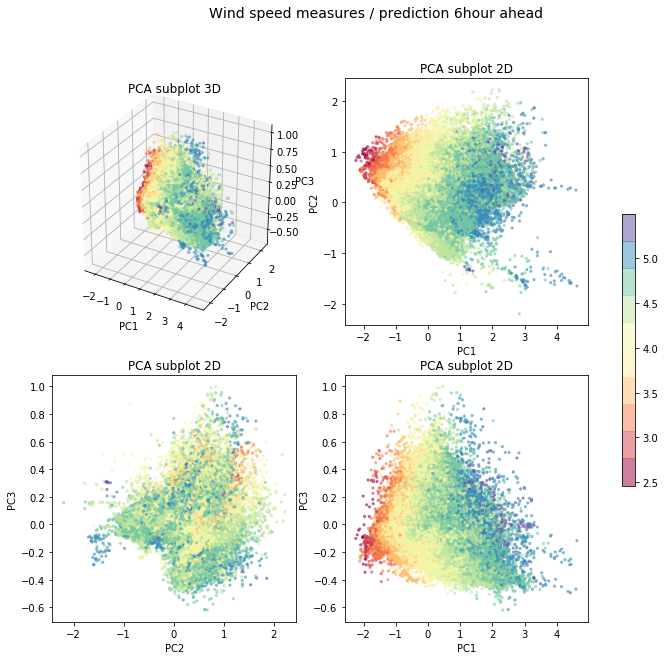

In [20]:
plot_PCA3(df_data.CNN_sep_2L_6h, projected, df_data.CNN_sep_2L_6h.min(),df_data.CNN_sep_2L_6h.max(),
          'wind_speed_6h', 'Wind speed measures / prediction 6hour ahead')

(126661,) 3.5439838785865057 9.915416362091458


<Figure size 1440x1440 with 0 Axes>

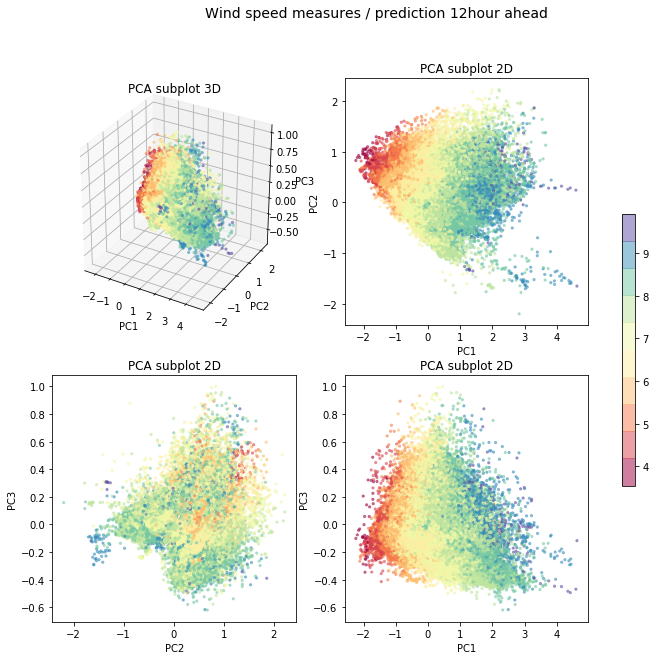

In [21]:
plot_PCA3(df_data.CNN_sep_2L_12h, projected, df_data.CNN_sep_2L_12h.min(),df_data.CNN_sep_2L_12h.max(),
          'wind_speed_12h', 'Wind speed measures / prediction 12hour ahead')

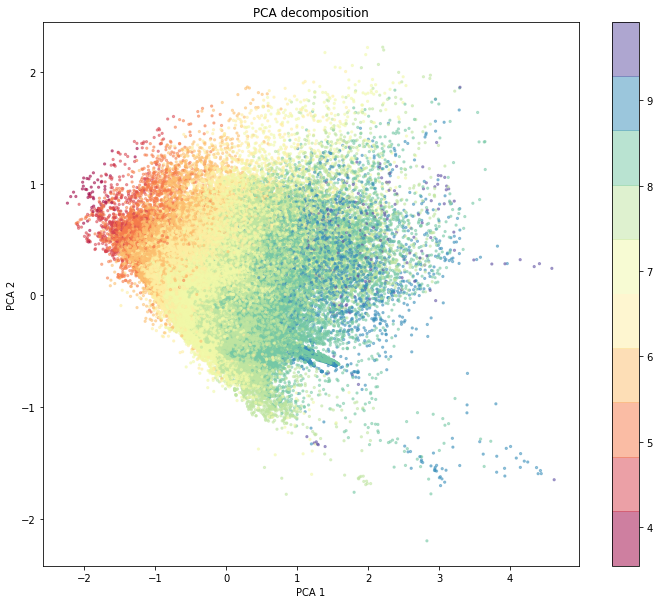

In [22]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)

plt.scatter(projected['PCA0'], projected['PCA1'], c=df_data.CNN_sep_2L_12h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
ax.set_title('PCA decomposition')
plt.show()


In [23]:
#now temperature
df_forPCA_temp = pd.DataFrame({ 
                     'Trend12h_temperature':t1[:,1], 
                     'Trend24h_temperature':t3[:,1], 'Trend1m_temperature':t4[:,1],
                     'Season24h_temperature':t5[:,1], 'Season1m_temperature':t6[:,1], 'Season12h_temperatured':t7[:,1],
                     'SampEnt_temperature':t2[:,1], 'SpecEnt_temperature':t7[:,1],
                     'Stab1w_temperature':t8[:,1], 'Lump1w_temperature':t9[:,1]})
df_forPCA_temp = df_forPCA_temp.dropna()
#data_sampled = data.sample(n=50000)

In [24]:
print(df_forPCA.columns)

Index(['Trend12h_wind_speed', 'Trend24h_wind_speed', 'Trend1m_wind_speed',
       'Season24h_wind_speed', 'Season1m_wind_speed', 'Season12h_wind_speed',
       'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
       'Lump1w_wind_speed'],
      dtype='object')


In [25]:
pca = PCA(3)  # project from 12 to 2 dimensions
pca.fit(df_forPCA_temp)
projected_temp = pd.DataFrame(pca.transform(df_forPCA_temp), columns=['PCA%i' % i for i in range(3)], index=df_forPCA_temp.index)
print(df_forPCA_temp.shape)
print(projected_temp.shape)

(126691, 10)
(126691, 3)


(126691,) 2.4599077151215445 5.488184120301994


<Figure size 1440x1440 with 0 Axes>

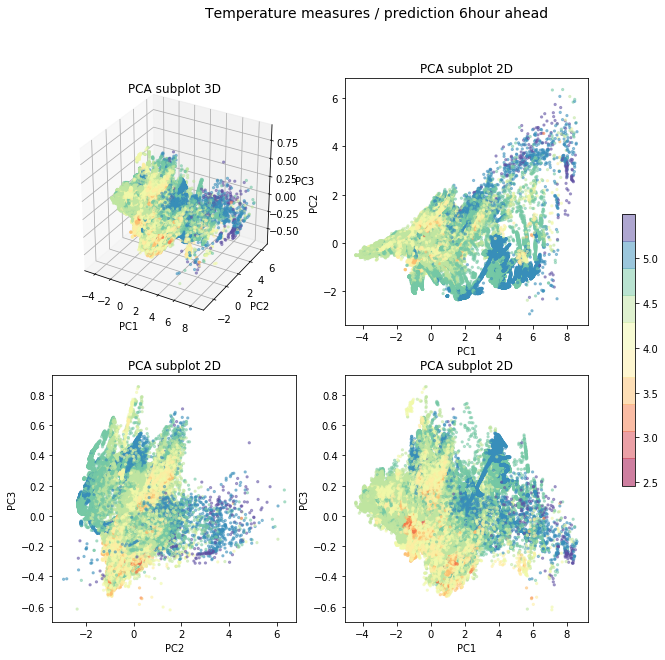

In [26]:
plot_PCA3(df_data_temp.CNN_sep_2L_6h, projected_temp, df_data_temp.CNN_sep_2L_6h.min(),df_data_temp.CNN_sep_2L_6h.max(),
          'Temperature_6h', 'Temperature measures / prediction 6hour ahead')

(126691,) 0.5050298192361149 0.9589249813832003


<Figure size 1440x1440 with 0 Axes>

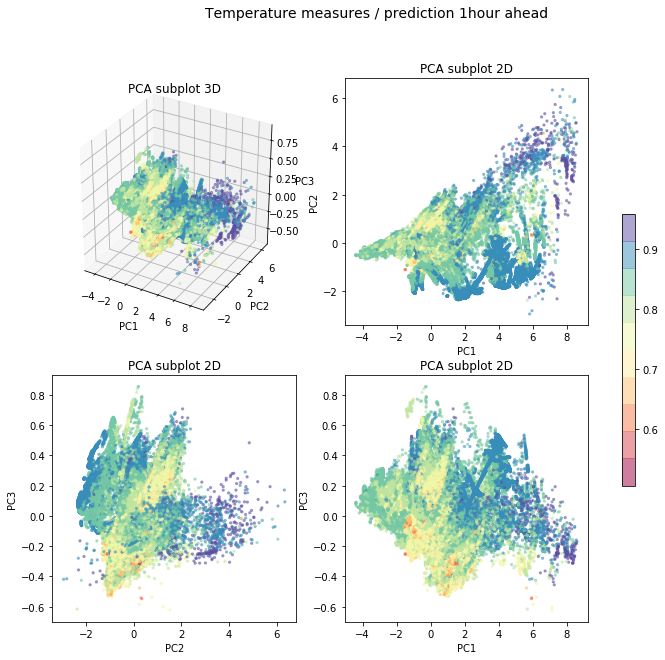

In [27]:
plot_PCA3(df_data_temp.CNN_sep_2L_1h, projected_temp, df_data_temp.CNN_sep_2L_1h.min(),df_data_temp.CNN_sep_2L_1h.max(),
          'Temperature_1h', 'Temperature measures / prediction 1hour ahead')

(126691,) 3.5439838785865057 9.915416362091458


<Figure size 1440x1440 with 0 Axes>

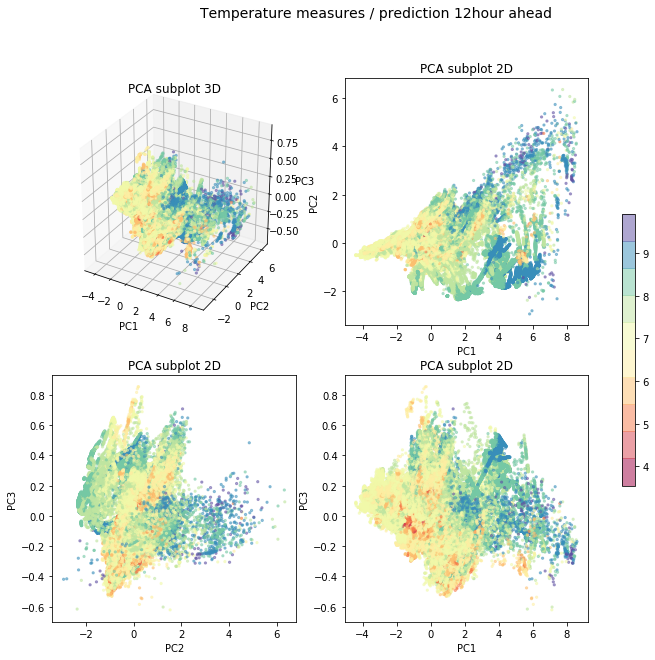

In [28]:
plot_PCA3(df_data_temp.CNN_sep_2L_12h, projected_temp, df_data_temp.CNN_sep_2L_12h.min(),df_data_temp.CNN_sep_2L_12h.max(),
          'Temperature_12h', 'Temperature measures / prediction 12hour ahead')

### TSNE decomposition 2 components

In [29]:
# Incluimos PCA como features para TSNE
df_forTSNE = df_forPCA

In [30]:
# Añadimos PCA como features para TSNE
df_forTSNE_plus_PCA = df_forPCA
df_forTSNE_plus_PCA['PCA0']= projected['PCA0']
df_forTSNE_plus_PCA['PCA1']= projected['PCA1']
df_forTSNE_plus_PCA['PCA2']= projected['PCA2']

In [31]:
tsne_em1 = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(df_forTSNE_plus_PCA)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 126661 samples in 0.942s...
[t-SNE] Computed neighbors for 126661 samples in 17.646s...
[t-SNE] Computed conditional probabilities for sample 1000 / 126661
[t-SNE] Computed conditional probabilities for sample 2000 / 126661
[t-SNE] Computed conditional probabilities for sample 3000 / 126661
[t-SNE] Computed conditional probabilities for sample 4000 / 126661
[t-SNE] Computed conditional probabilities for sample 5000 / 126661
[t-SNE] Computed conditional probabilities for sample 6000 / 126661
[t-SNE] Computed conditional probabilities for sample 7000 / 126661
[t-SNE] Computed conditional probabilities for sample 8000 / 126661
[t-SNE] Computed conditional probabilities for sample 9000 / 126661
[t-SNE] Computed conditional probabilities for sample 10000 / 126661
[t-SNE] Computed conditional probabilities for sample 11000 / 126661
[t-SNE] Computed conditional probabilities for sample 12000 / 126661
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 118000 / 126661
[t-SNE] Computed conditional probabilities for sample 119000 / 126661
[t-SNE] Computed conditional probabilities for sample 120000 / 126661
[t-SNE] Computed conditional probabilities for sample 121000 / 126661
[t-SNE] Computed conditional probabilities for sample 122000 / 126661
[t-SNE] Computed conditional probabilities for sample 123000 / 126661
[t-SNE] Computed conditional probabilities for sample 124000 / 126661
[t-SNE] Computed conditional probabilities for sample 125000 / 126661
[t-SNE] Computed conditional probabilities for sample 126000 / 126661
[t-SNE] Computed conditional probabilities for sample 126661 / 126661
[t-SNE] Mean sigma: 0.023126
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.295792
[t-SNE] KL divergence after 1000 iterations: 3.062055


In [32]:
result_plus_PCA = pd.DataFrame()
result_plus_PCA['tsne-2d-one'] = tsne_em1[:,0]
result_plus_PCA['tsne-2d-two'] = tsne_em1[:,1]

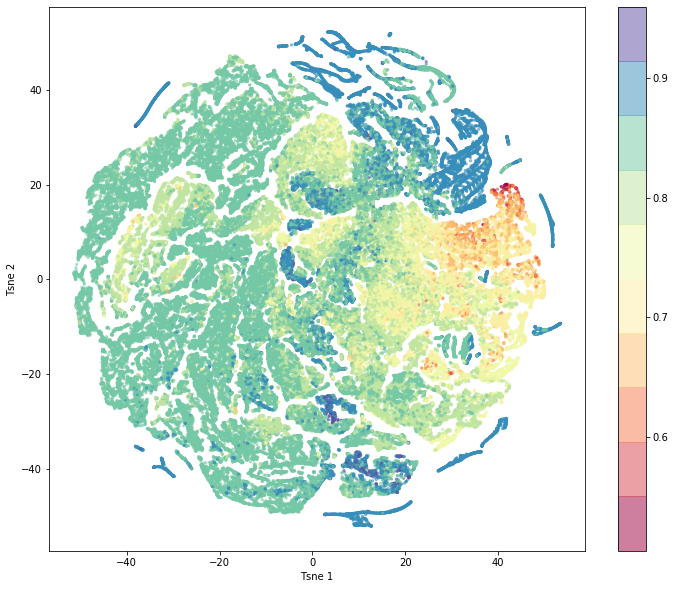

In [33]:
# Plot tsne 2D  MATPLOTLIB 1h

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
plt.scatter(result_plus_PCA['tsne-2d-one'], result_plus_PCA['tsne-2d-two'],c=df_data.CNN_sep_2L_1h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
plt.show()

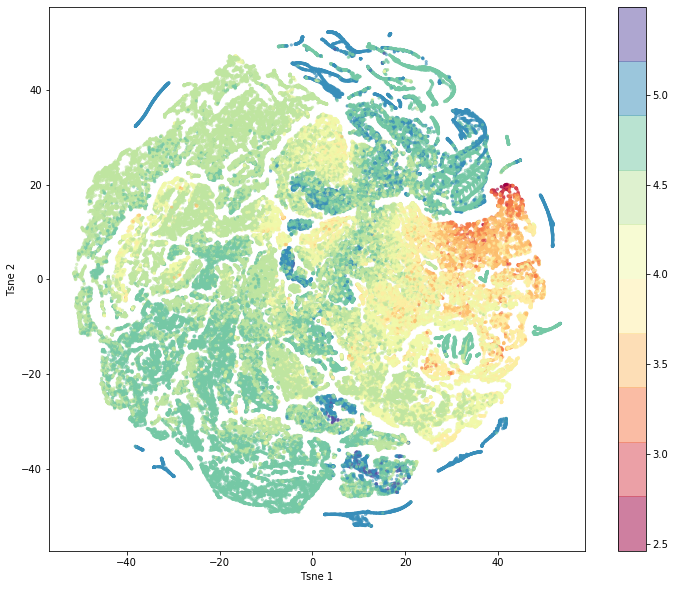

In [34]:
# Plot tsne 2D  MATPLOTLIB  6h

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
plt.scatter(result_plus_PCA['tsne-2d-one'], result_plus_PCA['tsne-2d-two'],c=df_data.CNN_sep_2L_6h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
plt.show()

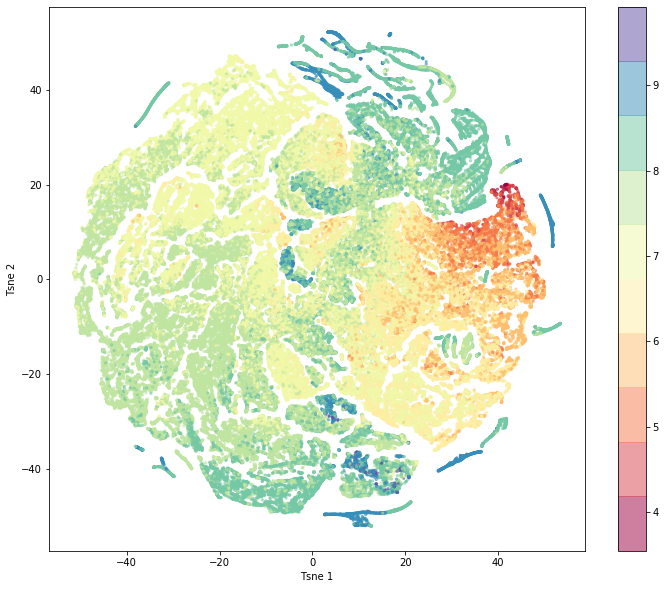

In [35]:
# Plot tsne 2D  MATPLOTLIB 12h

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
plt.scatter(result_plus_PCA['tsne-2d-one'], result_plus_PCA['tsne-2d-two'],c=df_data.CNN_sep_2L_12h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
plt.show()

##### TSNE solo a partir de PCAS

In [36]:
df_forTSNE_only_PCA =  projected[['PCA0','PCA1','PCA2']].copy()

#new = old[['A', 'C', 'D']].copy()

In [37]:
tsne_em2 = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(df_forTSNE_only_PCA)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 126661 samples in 0.192s...
[t-SNE] Computed neighbors for 126661 samples in 4.987s...
[t-SNE] Computed conditional probabilities for sample 1000 / 126661
[t-SNE] Computed conditional probabilities for sample 2000 / 126661
[t-SNE] Computed conditional probabilities for sample 3000 / 126661
[t-SNE] Computed conditional probabilities for sample 4000 / 126661
[t-SNE] Computed conditional probabilities for sample 5000 / 126661
[t-SNE] Computed conditional probabilities for sample 6000 / 126661
[t-SNE] Computed conditional probabilities for sample 7000 / 126661
[t-SNE] Computed conditional probabilities for sample 8000 / 126661
[t-SNE] Computed conditional probabilities for sample 9000 / 126661
[t-SNE] Computed conditional probabilities for sample 10000 / 126661
[t-SNE] Computed conditional probabilities for sample 11000 / 126661
[t-SNE] Computed conditional probabilities for sample 12000 / 126661
[t-SNE] Computed conditional probabi

[t-SNE] Computed conditional probabilities for sample 124000 / 126661
[t-SNE] Computed conditional probabilities for sample 125000 / 126661
[t-SNE] Computed conditional probabilities for sample 126000 / 126661
[t-SNE] Computed conditional probabilities for sample 126661 / 126661
[t-SNE] Mean sigma: 0.012119
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.990654
[t-SNE] KL divergence after 1000 iterations: 3.000559


In [38]:
print(df_forTSNE_only_PCA.columns)

Index(['PCA0', 'PCA1', 'PCA2'], dtype='object')


In [39]:
result_only_PCA = pd.DataFrame()
result_only_PCA['tsne-2d-one'] = tsne_em2[:,0]
result_only_PCA['tsne-2d-two'] = tsne_em2[:,1]

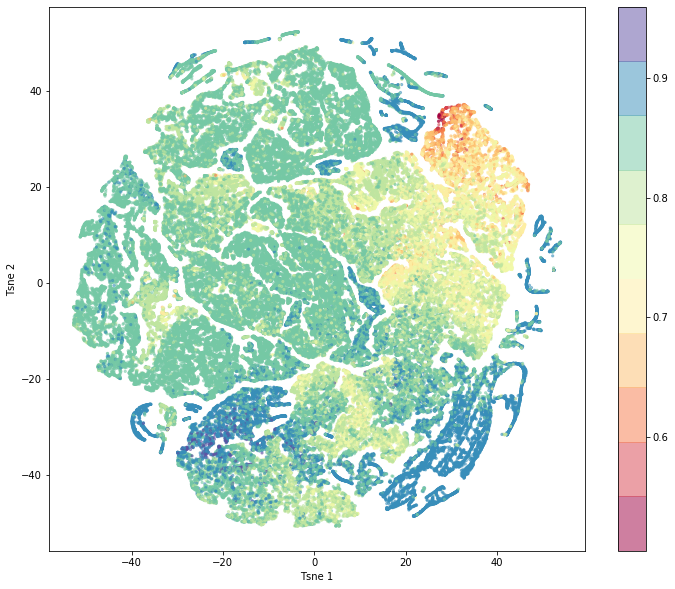

In [40]:
# Plot tsne 2D  MATPLOTLIB 1h

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
plt.scatter(result_only_PCA['tsne-2d-one'], result_only_PCA['tsne-2d-two'],c=df_data.CNN_sep_2L_1h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
fig.savefig('e:/figures/'+ 'TSNE_1h' +'.png', dpi=300)
plt.show()

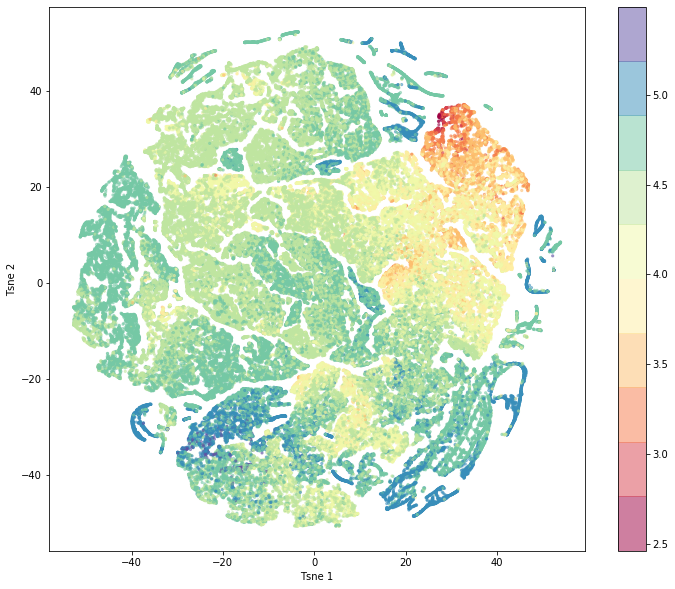

In [41]:
# Plot tsne 2D  MATPLOTLIB 6h

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
plt.scatter(result_only_PCA['tsne-2d-one'], result_only_PCA['tsne-2d-two'],c=df_data.CNN_sep_2L_6h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
fig.savefig('e:/figures/'+ 'TSNE_6h' +'.png', dpi=300)
plt.show()

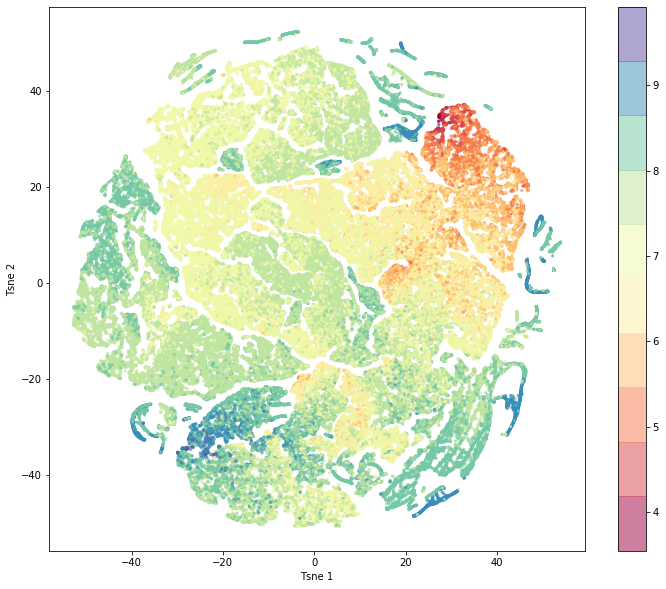

In [42]:
# Plot tsne 2D  MATPLOTLIB 12h

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
plt.scatter(result_only_PCA['tsne-2d-one'], result_only_PCA['tsne-2d-two'],c=df_data.CNN_sep_2L_12h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
fig.savefig('e:/figures/'+ 'TSNE_12h' +'.png', dpi=300)
plt.show()

In [43]:
##### TSNE sin PCA
df_TSNE = df_forPCA

In [44]:
print(df_TSNE.columns)

Index(['Trend12h_wind_speed', 'Trend24h_wind_speed', 'Trend1m_wind_speed',
       'Season24h_wind_speed', 'Season1m_wind_speed', 'Season12h_wind_speed',
       'SampEnt_wind_speed', 'SpecEnt_wind_speed', 'Stab1w_wind_speed',
       'Lump1w_wind_speed', 'PCA0', 'PCA1', 'PCA2'],
      dtype='object')


In [45]:
tsne_em3 = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(df_TSNE)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 126661 samples in 0.934s...
[t-SNE] Computed neighbors for 126661 samples in 17.735s...
[t-SNE] Computed conditional probabilities for sample 1000 / 126661
[t-SNE] Computed conditional probabilities for sample 2000 / 126661
[t-SNE] Computed conditional probabilities for sample 3000 / 126661
[t-SNE] Computed conditional probabilities for sample 4000 / 126661
[t-SNE] Computed conditional probabilities for sample 5000 / 126661
[t-SNE] Computed conditional probabilities for sample 6000 / 126661
[t-SNE] Computed conditional probabilities for sample 7000 / 126661
[t-SNE] Computed conditional probabilities for sample 8000 / 126661
[t-SNE] Computed conditional probabilities for sample 9000 / 126661
[t-SNE] Computed conditional probabilities for sample 10000 / 126661
[t-SNE] Computed conditional probabilities for sample 11000 / 126661
[t-SNE] Computed conditional probabilities for sample 12000 / 126661
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 125000 / 126661
[t-SNE] Computed conditional probabilities for sample 126000 / 126661
[t-SNE] Computed conditional probabilities for sample 126661 / 126661
[t-SNE] Mean sigma: 0.023126
[t-SNE] KL divergence after 250 iterations with early exaggeration: 100.520851
[t-SNE] KL divergence after 1000 iterations: 3.037689


In [46]:
result = pd.DataFrame()
result['tsne-2d-one'] = tsne_em3[:,0]
result['tsne-2d-two'] = tsne_em3[:,1]

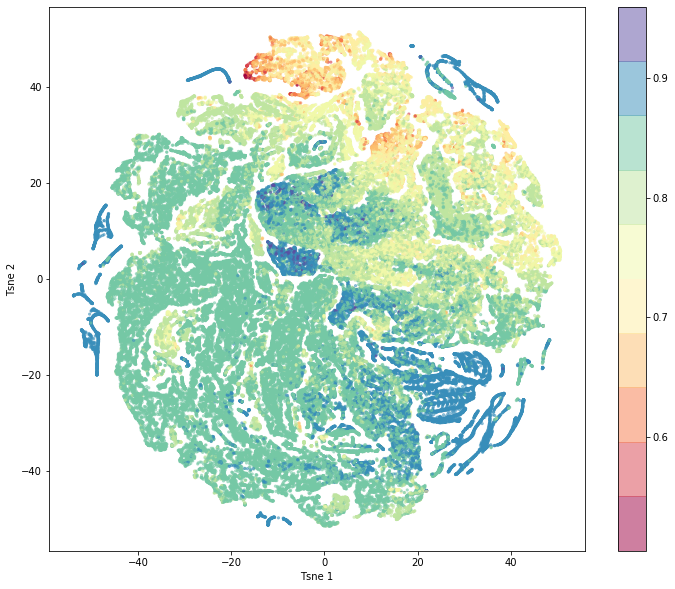

In [47]:
# Plot tsne 2D  MATPLOTLIB 1h

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
plt.scatter(result['tsne-2d-one'], result['tsne-2d-two'],c=df_data.CNN_sep_2L_1h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
plt.show()

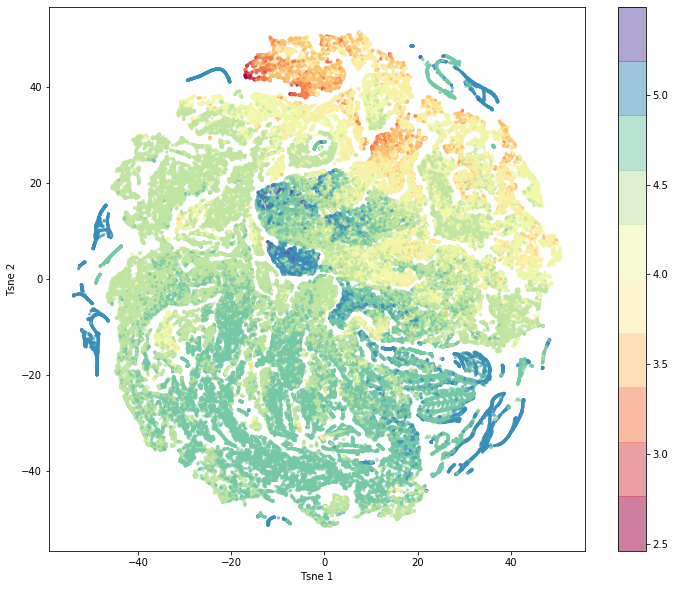

In [48]:
# Plot tsne 2D  MATPLOTLIB 6h

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
plt.scatter(result['tsne-2d-one'], result['tsne-2d-two'],c=df_data.CNN_sep_2L_6h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
plt.show()

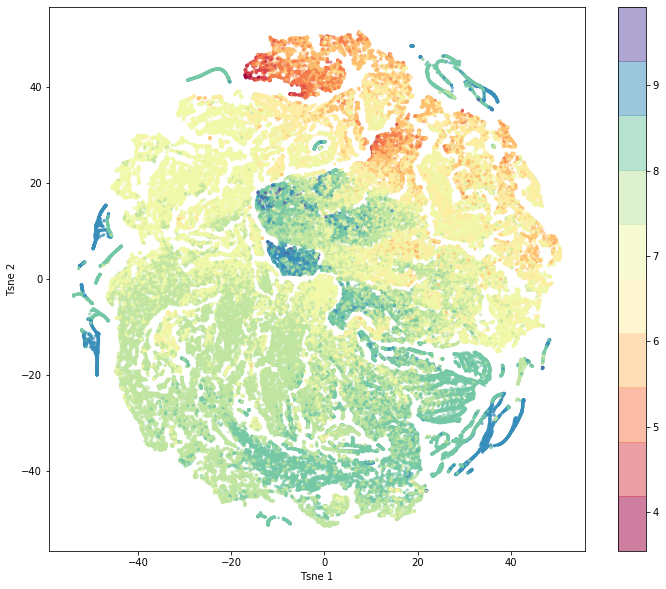

FileNotFoundError: [Errno 2] No such file or directory: 'e:/$Notebooks/figures/TSNE-NO-PCA.png'

In [49]:
# Plot tsne 2D  MATPLOTLIB 12h

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
plt.scatter(result['tsne-2d-one'], result['tsne-2d-two'],c=df_data.CNN_sep_2L_12h, s= 5, 
             alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Tsne 1')
plt.ylabel('Tsne 2')
plt.colorbar();
plt.show()